# Homework 04

## Group 10

This week we are using our learned power for good and create a neural network for automatic malaria detection.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

Let's first load our dataset and take a brief look at it using the built-in `show_examples()` method of the tensorflow datasets. The data only comes with a predefined training split. To get testing data to measure the performance of our model, we split the training set up. To make adjusting the split a little easier, we'll give you a parameter for this. Just choose how many percent of the data you want to use for training.

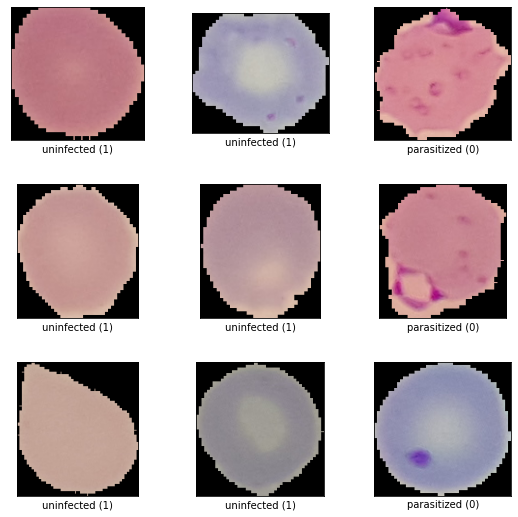

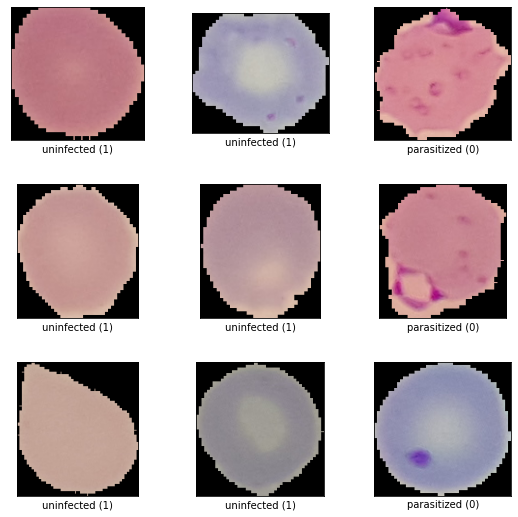

In [2]:
split_size = "80%"
(train_data, test_data), info = tfds.load(
    "malaria",
    split=[f"train[:{split_size}]", f"train[{split_size}:]"],
    as_supervised=True,
    with_info=True
    )

tfds.show_examples(train_data, info)

How is our data structured? First we are going to look at how many classes we have, and how many samples are in the training and testing set after the split.

In [3]:
print(f"Classes: {info.features['label'].names}")

print(f"Training set size: {tf.data.experimental.cardinality(train_data)}")
print(f"Testing set size: {tf.data.experimental.cardinality(test_data)}")

Classes: ['parasitized', 'uninfected']
Training set size: 22046
Testing set size: 5512


In [4]:
for image, _ in train_data.take(5):
    print("Image shape: ", image.numpy().shape)

Image shape:  (103, 103, 3)
Image shape:  (106, 121, 3)
Image shape:  (139, 142, 3)
Image shape:  (130, 118, 3)
Image shape:  (121, 109, 3)


Our images are not equally sized. Luckily tensorflow gives an Image API which allows us to resize the image. Note that there is also an `image.resize()` function, but using it will result in distortion if the images aspect ratio does not match the target ration, square in our case. So we will use `resize_with_pad()` instead.

In [5]:
train_data = train_data.map(lambda img, label: (tf.image.resize_with_pad(img, 128, 128), tf.one_hot(label,1)))
test_data = test_data.map(lambda img, label: (tf.image.resize_with_pad(img, 128, 128), tf.one_hot(label,1)))

A lot is happening in the cell above, so let's break it down:

1. With `map` we apply the following operation to every single element in the set.
2. Resize the image to 128x128 pixels by either cropping or padding the image. The decision is made by tensorflow.
3. Onehotify our label.

Verify that it worked by printing some examples.

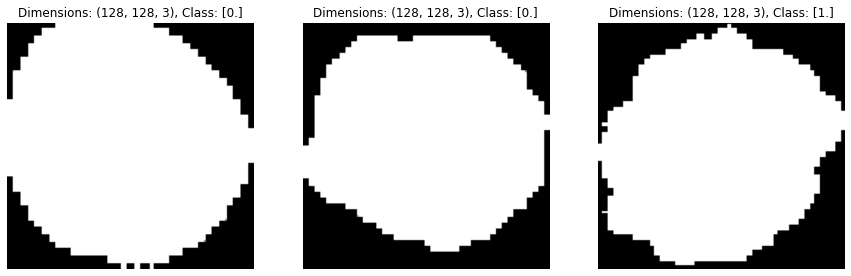

In [6]:
fig, axis = plt.subplots(ncols = 3, figsize=(15, 15))

for i, (image, label) in enumerate(train_data.take(3)):
    axis[i].imshow(image)
    axis[i].axis("off") # Do not display any axis label
    axis[i].set_title(f"Dimensions: {image.numpy().shape}, Class: {label.numpy()}")
plt.show()


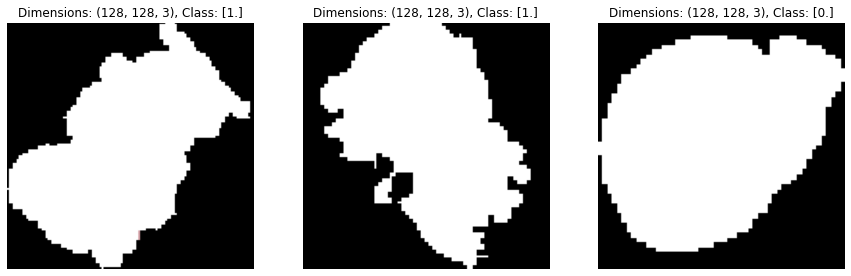

In [7]:
fig, axis = plt.subplots(ncols = 3, figsize=(15, 15))

for i, (image, label) in enumerate(test_data.take(3)):
    axis[i].imshow(image)
    axis[i].axis("off") # Do not display any axis label
    axis[i].set_title(f"Dimensions: {image.numpy().shape}, Class: {label.numpy()}")
plt.show()


Now a little experiment. We know that each pixel is represented with 3 Colors (Red, Green, Blue). In the following we will convert the images into grayscale to only work with one value. In this way the cell coloring is not important anymore but rather the contrast which shows infected areas.

In [8]:
train_data_bw = train_data.map(lambda img, label: (tf.image.rgb_to_grayscale(img), label))
test_data_bw = test_data.map(lambda img, label: (tf.image.rgb_to_grayscale(img), label))

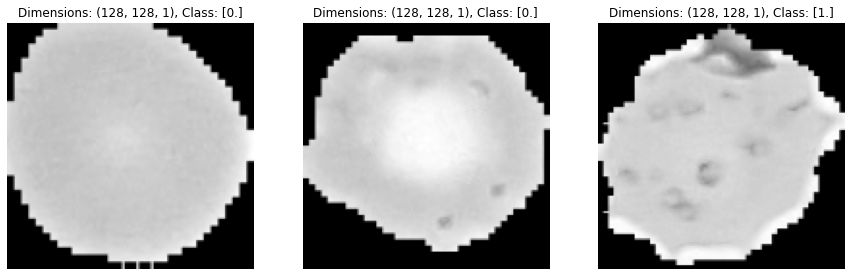

In [9]:
fig, axis = plt.subplots(ncols = 3, figsize=(15, 15))

for i, (image, label) in enumerate(train_data_bw.take(3)):
    axis[i].imshow(image, cmap="gray") # Otherwise matplotlib will apply its default colorscheme
    axis[i].axis("off") # Do not display any axis label
    axis[i].set_title(f"Dimensions: {image.numpy().shape}, Class: {label.numpy()}")
plt.show()

In [10]:
# Prepare the data

train_data = train_data.shuffle(buffer_size=64)
train_data = train_data.batch(64)
train_data = train_data.prefetch(buffer_size=64)

test_data = test_data.shuffle(buffer_size=64)
test_data = test_data.batch(64)
test_data = test_data.prefetch(buffer_size=64)

# And the same for our grayscale set

train_data_bw = train_data_bw.shuffle(buffer_size=64)
train_data_bw = train_data_bw.batch(64)
train_data_bw = train_data_bw.prefetch(buffer_size=64)

test_data_bw = test_data_bw.shuffle(buffer_size=64)
test_data_bw = test_data_bw.batch(64)
test_data_bw = test_data_bw.prefetch(buffer_size=64)

In [11]:
class Model(tf.keras.Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv_1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,
                                               activation=tf.keras.activations.relu,
                                             input_shape = (128,128,3)
                                               )
        self.max_pool_1 = tf.keras.layers.MaxPool2D()
        self.conv_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3,
                                               activation=tf.keras.activations.relu,
                                               )
        self.max_pool_2 = tf.keras.layers.MaxPool2D()
        self.conv_3 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3,
                                               activation=tf.keras.activations.relu,
                                               )
        self.max_pool_3 = tf.keras.layers.MaxPool2D()
        self.conv_4 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3,
                                               activation=tf.keras.activations.relu,
                                               )
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid)
                                               
       
    def call(self, x):
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.max_pool_3(x)
        x = self.conv_4(x)
        x = self.global_pool(x)
        return self.output_layer(x)

In [12]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [13]:
%%time
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 3
learning_rate = 0.01
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_data, binary_cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_data, binary_cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_data.shuffle(buffer_size=128)
    test_dataset = test_data.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_data:
        train_loss = train_step(model, input, target, binary_cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_data, binary_cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
CPU times: user 2h 7min 4s, sys: 23min 28s, total: 2h 30min 32s
Wall time: 28min 46s


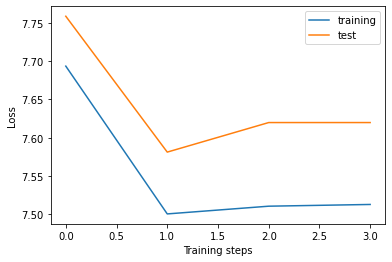

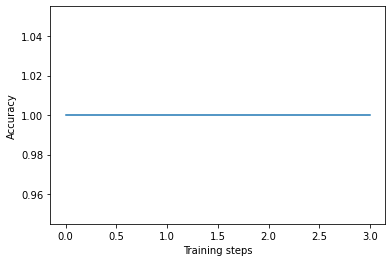

In [14]:

# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()